<a href="https://colab.research.google.com/github/Flammingo2/TensorFlow/blob/main/homework6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [208]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [209]:
#Load the dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)
255
0
[[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]
 [4]
 [7]
 [7]
 [2]
 [9]
 [9]
 [9]
 [3]
 [2]
 [6]]


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


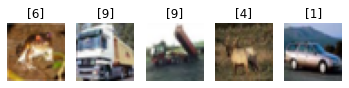

In [210]:
#Visualize the data
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)
print(np.max(train_images[0]))
print(np.min(train_images[0]))

print(train_labels[:20])

# Plot 5 samples with their corresponding label.
fig, ax = plt.subplots(1,5)
for i in range(5):

    # Readout an image and the corresponding label.
    img = train_images[i]
    lbl = train_labels[i]

    ax[i].imshow(img, cmap='gray')
    ax[i].set_title(lbl)
    ax[i].axis("off")

In [211]:
#Build input pipeline
#Build tensors
train_dataset_images = tf.data.Dataset.from_tensor_slices(train_images)
#Standardization of train input images
train_dataset_images = train_dataset_images.map(lambda image : tf.image.per_image_standardization(tf.cast(image, tf.float32)))  

train_dataset_targets = tf.data.Dataset.from_tensor_slices(train_labels)
#Train labels as onehot vectors
train_dataset_targets = train_dataset_targets.map(lambda t : tf.reshape(tf.one_hot(t, 10), (-1,)))

test_dataset_images = tf.data.Dataset.from_tensor_slices(test_images)
#Standardization of test input images
test_dataset_images = test_dataset_images.map(lambda image : tf.image.per_image_standardization(tf.cast(image, tf.float32)))

test_dataset_targets = tf.data.Dataset.from_tensor_slices(test_labels)
#Test labels as onehot vectors
test_dataset_targets = test_dataset_targets.map(lambda t : tf.one_hot(t, 10))

#Zip images and labels together to create train and test dataset
train_ds = tf.data.Dataset.zip((train_dataset_images, train_dataset_targets))
test_ds = tf.data.Dataset.zip((test_dataset_images, test_dataset_targets))

#Batching, shuffling and prefetching of datasets
train_ds = train_dataset.batch(64).shuffle(buffer_size=64).prefetch(128)
test_ds = test_dataset.batch(64).shuffle(buffer_size=64).prefetch(128)

In [212]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

#Defining a Residual Block consisting of 3 convolution/batch normalization alterations
class ResidualBlock(Layer):

    def __init__(self):
        super(ResidualBlock, self).__init__()
        self.batch_normalization_layer_1 = tf.keras.layers.BatchNormalization()
        self.convolution_layer_1 = tf.keras.layers.Conv2D(filters=32,
                                                     kernel_size=1,
                                                     strides=(1,1),
                                                     padding='same', 
                                                     activity_regularizer=tf.keras.regularizers.L2(0.01),                                           
                                                     input_shape=(64,32,32,32)                                                    
                                               )

        self.batch_normalization_layer_2 = tf.keras.layers.BatchNormalization()
        self.convolution_layer_2 = tf.keras.layers.Conv2D(filters=32,
                                                     kernel_size=3,
                                                     strides=(1,1),
                                                     padding='same', 
                                                     activity_regularizer=tf.keras.regularizers.L2(0.01)                                                                                              
                                               )
        
        self.batch_normalization_layer_3 = tf.keras.layers.BatchNormalization()
        self.convolution_layer_3 = tf.keras.layers.Conv2D(filters=32,
                                                     kernel_size=3,
                                                     strides=(1,1),
                                                     padding='same', 
                                                     activity_regularizer=tf.keras.regularizers.L2(0.01)                                                  
                                               )
        
    def call(self, x, training = False):

      input = x

      # Define the forward step.
      x = self.batch_normalization_layer_1(x, training)
      x = self.convolution_layer_1(x)
      x = tf.keras.activations.relu(x)

      x = self.batch_normalization_layer_2(x, training)
      x = self.convolution_layer_2(x)
      x = tf.keras.activations.relu(x)

      x = self.batch_normalization_layer_3(x, training)
      x = self.convolution_layer_3(x)
      x = tf.keras.activations.relu(x)

      return input + x


In [213]:
#Build a Residual Layer Network
class ResNet(Model): 
    # depth as number of iterations of residual block
    def __init__(self, depth):
        super(ResNet, self).__init__()

        # Define the three layers.
        self.convolution_layer_1 = tf.keras.layers.Conv2D(filters=32,
                                                     kernel_size=3,
                                                     strides=(1,1),
                                                     padding='same', 
                                                     activity_regularizer=tf.keras.regularizers.L2(0.01),                                           
                                                     input_shape=(64,32,32,3),
                                                     activation = tf.keras.activations.relu                                                    
                                               )
        
        #Iteration of ResidualBlock of length depth
        self.residual_blocks = []
        for i in range(depth):
          self.residual_blocks.append(ResidualBlock())
        #self.residual_blocks = [ResidualBlock((64,32,32,3)) for i in range(depth)]

        self.global_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()
        self.output_layer = tf.keras.layers.Dense(units=10, 
                                                  activation=tf.keras.activations.softmax)

    def call(self, x, training = False):
        # Define the forward step.
        x = self.convolutional_layer1(x)
        for block in self.residual_blocks:
          x = block(x, training)
       
        x = self.global_pooling_layer(x)
        x = self.output_layer(x)

        return x

In [214]:
#Defining a Transitional Layer with
class TransitionalLayer(Layer):

  def __init__(self, input_shape):

    super(TransitionalLayer, self).__init__()

    self.convolution_layer_1= tf.keras.layers.Conv2D(filters= input_shape[-1]/2, 
                                              kernel_size= 1,
                                              strides=(1, 1), 
                                              padding='same',
                                              input_shape = input_shape,
                                              kernel_regularizer=tf.keras.regularizers.L2(0.01)
                                              )
    self.batch_normalization_layer_1 = tf.keras.layers.BatchNormalization()

    self.pooling_layer_1 = tf.keras.layers.AveragePooling2D(pool_size=(1,1))
    
    

  def call(self, x, training = False):

    #Define a forward step
    x = self.convolution_layer_1(x)
    x = self.batch_normalization_layer_1(x)
    x = tf.keras.activations.relu(x)
    x = self.pooling_layer_1(x)
    
    return x

In [215]:
#Building a Dense Block with overhanded iterations of Blocks
class DenseBlock(Layer):
  
  def __init__(self, input_shape, block_number = 3):
    super(DenseBlock, self).__init__()

    self.layers = []
    for i in range(block_number):
      self.layers.append(Block(input_shape))
    
  def call(self, x, training = False):
    
    for block in self.layers:
      x = block(x, training)
      
    return x

In [216]:
#Defining a Block with 1 convolutional layer and batch normalization 
class Block(DenseBlock):
  def __init__(self, input_shape):
    super(Block, self).__init__()

    self.convolution_layer_1 = tf.keras.layers.Conv2D(filters= input_shape[-1], 
                                       kernel_size= 3,
                                       strides=(1, 1), 
                                       padding='same',
                                       input_shape = input_shape,
                                       kernel_regularizer=tf.keras.regularizers.L2(0.01)
                                        )
    self.batch_normalization_layer_1 = tf.keras.layers.BatchNormalization()

    
  def call(self, x, training = False):
    input = x
    x = self.convolution_layer_1(x)
    x = self.batch_normalization_layer_1(x, training)
    x = tf.keras.activations.relu(x)
    x = tf.keras.layers.concatenate([input, x], axis=-1)

    return x

In [217]:
#Build Dense Network
class DenseNet(Model): 
    
    def __init__(self, denseblock_number = 3):
        super(DenseNet, self).__init__()

        # Define the three layers.
        self.convolutional_layer_1 = tf.keras.layers.Conv2D(filters= 32, 
                                                            kernel_size= 3,
                                                            strides=(1, 1), 
                                                            padding='same',
                                                            kernel_regularizer=tf.keras.regularizers.L2(0.01), 
                                                            activation = tf.keras.activations.relu,
                                                            input_shape = (64,32,32,3)
                                                            )
        
        self.list_of_alterations =[]
        for i in range(denseblock_number):
          self.list_of_alterations.append(DenseBlock((64,32,32,32)))

          self.list_of_alterations.append(TransitionalLayer((64,32,32,32)))

        self.batch_normalization_layer_1 = tf.keras.layers.BatchNormalization()
        self.global_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()
        self.output_layer = tf.keras.layers.Dense(units=10, activation=tf.keras.activations.softmax)

    def call(self, x, training = False):

        # Define the forward step.
        x = self.convolutional_layer1(x)

        #Delete last Transition Layer from List of functions to be executed
        del self.list_of_alterations[-1]
        for function in self.list_of_alterations:
          x = function(x, training)
        x = batch_normalization_layer_1(x, training)
        x = self.global_pooling_layer(x)
        x = self.output_layer(x)

        return x

In [218]:
#Pass on (number of convolution blocks in your dense blocks * growth rate on as the number of
#channels parameters to your Transition Layer

#filter of output match channels of input

In [219]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input, training=True)
    loss = loss_function(target, prediction) 
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test(model, test_data, loss_function, training=False):
  # test over complete test data
  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input, training)
    sample_test_loss = loss_function(target, prediction) 
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [220]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 23
learning_rate = tf.optimizers.schedules.ExponentialDecay(0.001, 5000, 0.97, staircase=True)
running_average_factor = 0.95

# Initialize the ResNet model.
model = ResNet(depth=3)
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_ds, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    train_ds = train_ds.shuffle(buffer_size=128)
    test_ds = test_ds.shuffle(buffer_size=128)

    #training (and checking in with training)
    running_average = 0
    for (input,target) in train_ds:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    #testing
    test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    #Print accuracy
    print(test_accuracies[-1])

    # Visualize accuracy and loss for training and test data. 
    # One plot training and test loss.
    # One plot training and test accuracy.
    plt.figure()
    line1, = plt.plot(train_losses)
    line2, = plt.plot(test_losses)
    plt.xlabel("Training steps")
    plt.ylabel("Loss")
    plt.legend((line1,line2),("training","test"))
    plt.show()

    plt.figure()
    line1, = plt.plot(test_accuracies)
    plt.xlabel("Training steps")
    plt.ylabel("Accuracy")
    plt.show()

InvalidArgumentError: ignored